In [2]:
# %pip install --upgrade pip
# %pip install pandas
# %pip install numpy
# %pip install datetime
# %pip install collections
# %pip install matplotlib.pyplot
# %pip install seaborn
# %pip install pyyaml
# %pip install jsonlines
# %pip install requests
# %pip install datasets
# %pip install torch
# %pip install scikit-learn
# %pip install tabulate

# %pip install statsmodels

In [3]:
import sys
import os
import re
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import barplot_distribution, plot_confusion_matrix, tabulate_annotation_pair_summary, analyze_pair_annotations

%load_ext autoreload
%autoreload 2

## Load Dataset + Annotations

In [4]:
# FILL IN:
PATH_TO_DATASET = "../data/automatic_annotations_v0/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/gpto3mini-json-wildchat"
PATH_TO_LANGUAGE_ANNOTATIONS = "../data/automatic_annotations_v0/annotations_languages.jsonl"

In [5]:
# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 20 / 10127 failed due to invalid annotations.
turn-topic: 55 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 103 / 10127 failed due to invalid annotations.
prompt-media_format: 9 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


In [6]:
annotation_pairs1 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
annotation_pairs2 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=False,
)

outdir = f"../data/annotation_analysis_v0/topic"
os.makedirs(outdir, exist_ok=True)
fig = barplot_distribution(
    {"Topics": annotation_pairs1}, normalize=True, 
    xlabel="Topics", ylabel="Proportion", title="",
    output_path=f"{outdir}/barchart.png", order="descending")

multibar_fig = barplot_distribution(
    {"Topics": annotation_pairs2}, normalize=True, 
    xlabel="Topics", ylabel="Proportion", title="",
    output_path=f"{outdir}/multilabel_barchart.png", order="descending")

/Users/chuanyang/Desktop/naturalistic-ai-chuanyang/notebooks/../src/helpers/visualisation.py:125: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


In [7]:
print(dataset.data[0])
print(vars(dataset.data[0]))

{'conversation_id': 'wildchat_553847317a397b5def89dae32fe9defd', 'dataset_id': 'wildchat_1m', 'user_id': '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a', 'time': '2023-04-25T02:20:46+00:00', 'model': 'gpt-3.5-turbo-0301', 'conversation': [<src.classes.message.Message object at 0x105957640>, <src.classes.message.Message object at 0x105954460>, <src.classes.message.Message object at 0x10582e260>, <src.classes.message.Message object at 0x31e121ba0>, <src.classes.message.Message object at 0x31e121c00>, <src.classes.message.Message object at 0x31e121b70>, <src.classes.message.Message object at 0x31e121b10>, <src.classes.message.Message object at 0x31e121ab0>, <src.classes.message.Message object at 0x31e121a50>, <src.classes.message.Message object at 0x31e1219f0>, <src.classes.message.Message object at 0x31e121990>, <src.classes.message.Message object at 0x31e121930>, <src.classes.message.Message object at 0x31e1218d0>, <src.classes.message.Message object at 0x31e121870>, 

In [8]:
annotation_pairs1 = dataset.get_annotation_distribution(
    "turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(annotation_pairs1)

{"['entertainment hobbies leisure']": 338, "['employment hiring']": 89, "['news current affairs']": 26, "['employment hiring', 'technology software computing']": 4, "['technology software computing']": 1956, "['food dining']": 66, "['culture', 'entertainment hobbies leisure', 'history']": 1, "['art design']": 407, "['fantasy fiction fanfiction']": 610, "['adult illicit content']": 516, "['adult illicit content', 'fantasy fiction fanfiction']": 118, "['adult illicit content', 'art design', 'fantasy fiction fanfiction']": 2, "['fantasy fiction fanfiction', 'news current affairs', 'politics elections', 'social issues movements']": 1, "['none']": 555, "['literature writing']": 214, "['education', 'interpersonal relationships communication', 'lifestyle', 'nature environment', 'technology software computing', 'travel tourism']": 1, "['education', 'linguistics languages']": 27, "['social issues movements']": 30, "['history', 'psychology philosophy human behavior', 'social issues movements']":

In [9]:
[name for name in dir(dataset) if not name.startswith('_')]

['add_annotations',
 'data',
 'dataset_id',
 'extract_all_metadata_values_for_annotation_source_name',
 'extract_conversation_metadata_by_ids',
 'find_conflicting_annotations',
 'find_conversations_by_metadata',
 'get_annotation_distribution',
 'get_confidence_distribution',
 'get_joint_distribution',
 'id_lookup',
 'load',
 'random_sample',
 'save_to_json',
 'slice',
 'to_dict']

In [10]:
from collections import Counter

# Count how many conversations each user_id has
user_counter = Counter()
for conv in dataset.data:
    user_counter[conv.user_id] += 1

# Find the first user_id with more than 100 conversations
for user_id, count in user_counter.items():
    # print(f"User ID: {user_id}, Conversations: {count}")
    if count > 10:
        print(f"First user_id with more than 10 conversations: {user_id} ({count} conversations)")
        # break

First user_id with more than 10 conversations: 2a28eab6a25a22abbe8a2de22f61e06101936bad97e1b8263c5061ade8f872b8 (29 conversations)
First user_id with more than 10 conversations: a89177c80571053584234edca85f348690bf0ab5873876a9486694cd7c15a1fb (22 conversations)
First user_id with more than 10 conversations: 3e7ae36b9ca739b0e16876727814a0e8470c8496aab833c49a5bcc7e77bb7f01 (43 conversations)
First user_id with more than 10 conversations: a5146fac10d0a974d79af83042eed65659396495d293967ddc1b69779ed35179 (21 conversations)
First user_id with more than 10 conversations: dec1f72ae4d94e369602348fc957b0d6781051aa664f2458ee53c19be1740dd7 (21 conversations)
First user_id with more than 10 conversations: a0e542c18e25a29832c7c59ca23d4c90e717b250624cd0ca578bd59670ec05c0 (11 conversations)
First user_id with more than 10 conversations: f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314 (11 conversations)
First user_id with more than 10 conversations: cbbbb1787dc8a36e05d2acfc474c9fcb32c2

In [11]:
target_user_id = '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a'

topics = []
for conv in dataset.data:
    print(conv.user_id)
    if conv.user_id == target_user_id:
        for message in conv.conversation:
            if "automatic_v0-turn_topic" in message.metadata.keys():
                topic = message.metadata["automatic_v0-turn_topic"].value
                topics.append(topic)

print(f"Number of topics: {len(topics)}")

8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a
fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a
3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6
e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c
c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8
9ea6d561a74c568b3de8c2559fa6809fdd1e60cb858f08d07e0c1e0527d4d47c
cb0338307c204b84305debd3b17f16ea0da5f54a29be74cf8e232f63e0386a8b
2ccbf1367575a6c36703fa7095cfe6b6e424983b85e61333ba5c6f6078fd2cf6
47c8ed61cf1f13af567136a8b8bf7e0434d824e5a6e9633e4db16c97c6b6b521
e2e91c20c4191837c72adf0c5284edabbf6f52317ba948dd4ca00c80badc02fb
9f6bbe7a5f031d521861999b8cee963202488504ed32279c7ba105dc5fb44be6
ef89468aa4572dd07d6a0cca7f49ec85874afa49c9b6bb367ef94e1106e8c65d
f48dbd9cd788089d2c80f5ba1cf89095ce6ee8cce65a3f43f5a3cfa453689781
7467776153377b6a5347d67868dd991dcda2636a3a721ff87e8764829c1621c6
de8493e4c2b03c865a169e95f12156fb4c1ea58519ff326e94c3711515b3b63b
a09988210a83b972a107d633a

In [12]:
target_user_id = '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a'

for conv in dataset.data:
    print(conv.user_id)
    if conv.user_id == target_user_id:
        for message in conv.conversation:
            if "automatic_v0-turn_topic" in message.metadata.keys():
                metadata = message.metadata
                print(metadata)

8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a
{'automatic_v0-prompt_multi_turn_relationship': <src.classes.annotation_record.AnnotationRecord object at 0x10574e7a0>, 'automatic_v0-prompt_interaction_features': <src.classes.annotation_record.AnnotationRecord object at 0x3417272e0>, 'automatic_v0-turn_sensitive_use_flags': <src.classes.annotation_record.AnnotationRecord object at 0x3427ae890>, 'automatic_v0-turn_topic': <src.classes.annotation_record.AnnotationRecord object at 0x3428d1ff0>, 'automatic_v0-prompt_function_purpose': <src.classes.annotation_record.AnnotationRecord object at 0x343ca09d0>, 'automatic_v0-prompt_media_format': <src.classes.annotation_record.AnnotationRecord object at 0x343d06950>}
{'automatic_v0-prompt_multi_turn_relationship': <src.classes.annotation_record.AnnotationRecord object at 0x10574e4d0>, 'automatic_v0-prompt_interaction_features': <src.classes.annotation_record.AnnotationRecord object at 0x341727310>, 'automatic_v0-turn_sensitive_us

In [13]:
target_user_id = '3e7ae36b9ca739b0e16876727814a0e8470c8496aab833c49a5bcc7e77bb7f01'

topics = []
for conv in dataset.data:
    if conv.user_id == target_user_id:
        for message in conv.conversation:
            if "automatic_v0-turn_topic" in message.metadata.keys():
                topic = message.metadata["automatic_v0-turn_topic"].value
                topics.append(topic)

print(f"Number of topics: {len(topics)}")

Number of topics: 56


In [14]:
print(topics)  # Print first 10 topics for verification

[['video games', 'entertainment hobbies leisure'], ['adult illicit content', 'fantasy fiction fanfiction'], ['adult illicit content', 'history', 'literature writing'], ['literature writing', 'history'], ['adult illicit content', 'literature writing'], ['fantasy fiction fanfiction'], ['adult illicit content', 'literature writing', 'geography'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction'], ['none'], ['adult illicit content'], ['none'], ['adult illicit content'], ['none'], ['none'], ['none'], ['fantasy fiction fanfiction', 'video games'], ['fantasy fiction fanfiction', 'entertainment hobbies leisure'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction'], ['entertainment hobbies leisure', 'adult illicit content'], ['adult illicit content'], ['adult illicit content'], ['fantasy fiction fanfiction'], ['fantasy fiction fanfiction', 'video games'], ['adult illicit content', 'fantasy fiction fanfiction'], ['adult illicit content', 'fantasy fiction fanfiction'], ['f

In [15]:
dataset.data[0].conversation[0].metadata

{'automatic_v0-prompt_multi_turn_relationship': <src.classes.annotation_record.AnnotationRecord at 0x10574e7a0>,
 'automatic_v0-prompt_interaction_features': <src.classes.annotation_record.AnnotationRecord at 0x3417272e0>,
 'automatic_v0-turn_sensitive_use_flags': <src.classes.annotation_record.AnnotationRecord at 0x3427ae890>,
 'automatic_v0-turn_topic': <src.classes.annotation_record.AnnotationRecord at 0x3428d1ff0>,
 'automatic_v0-prompt_function_purpose': <src.classes.annotation_record.AnnotationRecord at 0x343ca09d0>,
 'automatic_v0-prompt_media_format': <src.classes.annotation_record.AnnotationRecord at 0x343d06950>}

In [16]:
import json

with open(PATH_TO_LANGUAGE_ANNOTATIONS, 'r', encoding='utf-8') as f:
    data = json.load(f)  # Load entire file as one JSON object

target_id_to_language = {
    ann['target_id']: ann['value']
    for ann in data['annotations']
}

id_to_language = {}
for target_id, language in target_id_to_language.items():
    try:
        print(f"{target_id}: {language[0]}")
        id_to_language[target_id] = language[0]
    except Exception as e:
        print(f"Error processing target_id {target_id}: {e}")

wildchat_553847317a397b5def89dae32fe9defd-0: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-1: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-2: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-3: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-4: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-5: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-6: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-7: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-8: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-9: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-10: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-11: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-12: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-13: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-14: CHINESE
wildchat_553847317a397b5def89dae32fe9defd-15: CHINESE
wildchat_cead929b2b15f94b18de7a7eaa5fb733-0: ENGLISH
wildchat_cead929b2b15f94b18de7a7eaa5fb733-1: ENGLISH
wildchat_cead929b2b15f94b18de7a7eaa5fb73

In [17]:
# Add language annotations
for conv in dataset.data:
    print(vars(conv))
    for message in conv.conversation:
        if message.role == "user":
            message.metadata["language"] = id_to_language.get(conv.conversation_id + "-0", "unknown")
            print(f"Language: {message.metadata['language']}")

{'conversation_id': 'wildchat_553847317a397b5def89dae32fe9defd', 'dataset_id': 'wildchat_1m', 'user_id': '8fe04885ac7d4510a0f7695261f3285dff4529ce91d15f84dc6c5880977a556a', 'time': '2023-04-25T02:20:46+00:00', 'model': 'gpt-3.5-turbo-0301', 'conversation': [<src.classes.message.Message object at 0x105957640>, <src.classes.message.Message object at 0x105954460>, <src.classes.message.Message object at 0x10582e260>, <src.classes.message.Message object at 0x31e121ba0>, <src.classes.message.Message object at 0x31e121c00>, <src.classes.message.Message object at 0x31e121b70>, <src.classes.message.Message object at 0x31e121b10>, <src.classes.message.Message object at 0x31e121ab0>, <src.classes.message.Message object at 0x31e121a50>, <src.classes.message.Message object at 0x31e1219f0>, <src.classes.message.Message object at 0x31e121990>, <src.classes.message.Message object at 0x31e121930>, <src.classes.message.Message object at 0x31e1218d0>, <src.classes.message.Message object at 0x31e121870>, 

In [71]:
ENGLISH_ONLY = True

messages = defaultdict(str)
annotation_labels = defaultdict(str)

for conv in dataset.data:
    for message in conv.conversation:
        if message.role == "user":
            # Extract annotation values with error handling
            multi_turn_relationship = message.metadata['automatic_v0-prompt_multi_turn_relationship'].value[0] if 'automatic_v0-prompt_multi_turn_relationship' in message.metadata else 'unknown'
            interaction_features = message.metadata['automatic_v0-prompt_interaction_features'].value[0] if 'automatic_v0-prompt_interaction_features' in message.metadata else 'unknown'
            turn_topic = message.metadata['automatic_v0-turn_topic'].value[0] if 'automatic_v0-turn_topic' in message.metadata else 'unknown'
            function_purpose = message.metadata['automatic_v0-prompt_function_purpose'].value[0] if 'automatic_v0-prompt_function_purpose' in message.metadata else 'unknown'
            media_format = message.metadata['automatic_v0-prompt_media_format'].value[0] if 'automatic_v0-prompt_media_format' in message.metadata else 'unknown'

            annotation_label = f"""Mutli-turn: {multi_turn_relationship}
Interaction Features: {interaction_features}
Turn Topic: {turn_topic}
Function Purpose: {function_purpose}
Media Format: {media_format}
        """
            
            if ENGLISH_ONLY:
                if message.metadata.get("language", "unknown") == "ENGLISH":
                    messages[conv.user_id] += message.content + "\n"
                    annotation_labels[conv.user_id] += annotation_label + "\n"
            else:
                messages[conv.user_id] += message.content + "\n"
                annotation_labels[conv.user_id] += annotation_label + "\n"

# If you want to convert back to a normal dict:
messages = dict(messages)
annotation_labels = dict(annotation_labels)

# Example: print first 100 characters of one user’s messages
for uid, text in messages.items():
    print(f"{uid}: {text[:100]}...")
    break
for uid, label in annotation_labels.items():
    print(f"{uid}: {label[:100]}...")
    break

fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a: keywords "Carrot shape, mechanical pencil,0.5mm"
write a title and five-bulk descriptions , a long d...
fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a: Mutli-turn: first request
Interaction Features: none
Turn Topic: art design
Function Purpose: conten...


## User Embedding and Clustering

Method:

1. Build a corpus from all user message texts and filtering (length, language)

2. Generate text-embedding-3-large embeddings for the filtered corpus and save the embedding matrix to disk.

3. Fit a BERTopic model (with custom UMAP, HDBSCAN, and CountVectorizer) on the documents using the precomputed embeddings to discover topic clusters.

4. For each topic, sample representative prompts by filtering documents with high topic probability and reasonable length.

5. Use GPT-4o to summarize each topic into a short label and description, parse these into structured category/description fields, and build a dataframe with topic stats, percentages, and example prompts.

6. Plot the clusters (2D UMAP projection of embeddings)

In [ ]:
import openai
import os
# replace "..." with your OpenAI key.
os.environ["OPENAI_API_KEY"] = ...
openai.api_key = os.getenv("OPENAI_API_KEY")

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.backend import OpenAIBackend

In [21]:
messages

{'fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a': 'keywords "Carrot shape, mechanical pencil,0.5mm"\nwrite a title and five-bulk descriptions , a long description and some SEO keywords.\nIn japanese\n',
 '3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6': 'Give me some examples of meals with good macros from fast food chains that do not contain beans\n',
 'e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c': 'What is the "temperature" in the GPT models?\n\nhow does it work\n',
 'c1dd4cf7cd5e49b5a23e3a135ad7e445b2ad0351807525b2ef25cbdd40b584f8': "what is the Cognosys ai and how does it work?\nI wrote some notes on what to look for and ask during a house viewing with a real estate agent. Please take a look and analyze it for any errors or for ways to improve it such as wording or missing questions/concerts/whatever. Any feedback from you would be valuable. Here's what I have noted:\n\nQuestions to Ask During a House Viewing:\n\n    - Is th

In [73]:
annotation_labels

{'fa795c0023cd320f502366592ffcf73666a86c9eca161387ece66eec1fe8514a': 'Mutli-turn: first request\nInteraction Features: none\nTurn Topic: art design\nFunction Purpose: content generation other\nMedia Format: natural language\n        \nMutli-turn: new variation of prior task\nInteraction Features: none\nTurn Topic: art design\nFunction Purpose: translation language to language\nMedia Format: natural language\n        \n',
 '3cc9823b60008e82cad53972055bef7ee9900bae7e4dfb14e15e293f05a69dd6': 'Mutli-turn: first request\nInteraction Features: none\nTurn Topic: food dining\nFunction Purpose: content generation general prose discussion or explanation\nMedia Format: natural language\n        \n',
 'e483d078a0a90f7684f9950c45a370dfcf70ccdcc792cdbf1756e1fd38ab544c': 'Mutli-turn: first request\nInteraction Features: none\nTurn Topic: technology software computing\nFunction Purpose: information retrieval general info from web\nMedia Format: natural language\n        \nMutli-turn: extend deepen or 

In [92]:
embedding_type = "message_embedding"
# embedding_type = "annotation_label_embedding"

if embedding_type == "message_embedding":
    user_ids = list(messages.keys())
    corpus = [messages[uid] for uid in user_ids]
elif embedding_type == "annotation_label_embedding":
    user_ids = list(annotation_labels.keys())
    corpus = [annotation_labels[uid] for uid in user_ids]
print(f"Number of users: {len(corpus)}")
print(f"Number of corpus entries: {len(corpus)}")

filtered_corpus = [text for text in corpus if len(text) < 2000]
print(f"Number of filtered corpus entries: {len(filtered_corpus)}")

doc = filtered_corpus
# doc = filtered_corpus[:500]

client = openai.OpenAI()
embedding_model = OpenAIBackend(client, "text-embedding-3-large", batch_size=1000)
embeddings = embedding_model.embed(doc, verbose=True)

# save embeddings
save_path = ".."
np.save(f"{save_path}/embeddings.npy", embeddings)

Number of users: 1663
Number of corpus entries: 1663
Number of filtered corpus entries: 908


1it [00:07,  7.62s/it]


In [93]:
embeddings

array([[-0.01497593, -0.01501425, -0.00926607, ..., -0.01614089,
        -0.00856862,  0.00644946],
       [-0.0026264 ,  0.00621303, -0.03287503, ...,  0.0086736 ,
         0.00235318, -0.0059477 ],
       [-0.02994259, -0.04174934, -0.01148036, ...,  0.014354  ,
        -0.00677611,  0.02753016],
       ...,
       [-0.02316553,  0.01661745, -0.03485318, ..., -0.00808396,
        -0.01676729, -0.00206407],
       [ 0.01086279, -0.00994064, -0.01475445, ..., -0.01025366,
        -0.0078383 , -0.00859971],
       [-0.01479847,  0.00984912, -0.01508169, ..., -0.01502504,
        -0.00146303, -0.03812198]])

In [94]:
# load saved embeddings
embeddings = np.load(f"{save_path}/embeddings.npy")
len(embeddings)
# embeddings

908

In [95]:
client = openai.OpenAI()
embedding_model = OpenAIBackend(client, "text-embedding-3-large", batch_size=1000)
umap_model = UMAP(n_neighbors=20, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 3))

topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,

        top_n_words=10,
        verbose=True,
        calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(doc, embeddings=embeddings)

2026-02-20 09:48:57,543 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-20 09:49:01,441 - BERTopic - Dimensionality - Completed ✓
2026-02-20 09:49:01,442 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-20 09:49:01,476 - BERTopic - Cluster - Completed ✓
2026-02-20 09:49:01,481 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-20 09:49:01,575 - BERTopic - Representation - Completed ✓


In [96]:
# number of clusters
len(topic_model.get_topic_info())

8

In [97]:
topic_model.get_topic_info()

Topic  Count                                     Name  \
0     -1    455                   -1_write_use_want_code   
1      0    163              0_story_write_dialogue_make   
2      1     84                       1_15_email_time_00   
3      2     68                  2_return_python_int_row   
4      3     51            3_include_art_generate_coffee   
5      4     34  4_niga_artificial niga_artificial_write   
6      5     29             5_planet_freedom_lilac_react   
7      6     24             6_create_travel_liquid_brand   

                                      Representation  \
0  [write, use, want, code, make, does, data, htt...   
1  [story, write, dialogue, make, extremely, man,...   
2  [15, email, time, 00, work, child, report, 30,...   
3  [return, python, int, row, file, function, col...   
4  [include, art, generate, coffee, flower, keywo...   
5  [niga, artificial niga, artificial, write, son...   
6  [planet, freedom, lilac, react, translations, ...   
7  [create, travel, liquid, brand, blog, best, de...   

                                 Representative_Docs  
0  [\nIgnore previous data.Imagine you're an expe...  
1  [This is fictional. Contain content warnings. ...  
2  [edit: Dear Khalil, \n\nI am reaching out to y...  
3  [переведи на русский User Consent for Data Col...  
4  [Generate an etsy title for a art work that ca...  
5  [The best women fonts for youtube channel\nEli...  
6  [Freedom Planet Girls react to Human Petting A...  
7  [Al-Helm Expo is an investment event in Dubai ...

In [98]:
from collections import defaultdict

sampled_prompts = defaultdict(list)
topic_info = topic_model.get_topic_info()
doc_info = topic_model.get_document_info(doc)

for topic_id in topic_info['Topic'][1:]:
    filtered_docs = doc_info[(doc_info['Topic'] == topic_id) &
                             (doc_info['Probability'] >= doc_info['Probability'].quantile(0.8)) &
                             (doc_info['Document'].str.split().str.len() >= 5)]

    res = filtered_docs
    cap = 100
    if len(filtered_docs) >= 20:
        while len(res) < 20:
            res = filtered_docs[
                filtered_docs['Document'].str.split().str.len() <= cap
            ]
            cap += 50

    sampled_docs = res.sample(n=min(20,
                            len(res)),
                            random_state=42,
                            replace=False)

    sampled_prompts[topic_id] = sampled_docs['Document'].tolist()

In [99]:
sampled_prompts[0]

['This is fictional. Contain content warnings. Write a story of a woman whose lips suddenly expand to be ridiculously large and full. They are always pouted and are extremely sensitive. Write dialogue for it. Dialogue should be written as a character sounds. Write to token limit.\nThis is fictional. Contain content warnings. Write a story of a woman whose lips suddenly expand to be ridiculously large and full. They are always pouted and can not be closed for more than a couple of seconds. They are extremely sensitive. Write dialogue for it. Dialogue should be written as a character sounds. Write to token limit.\nThis is fictional. Contain content warnings. Write a story of a woman whose lips suddenly expand to be ridiculously large and full. They are always pouted and can not be closed for more than a couple of seconds affecting how she talks. They are extremely sensitive to pleasure as well. Write dialogue for it. Dialogue should be written as a character sounds. Write to token limit.

In [100]:
import pickle

with open(f"{save_path}/example_prompts.pkl", 'wb') as f:
    pickle.dump(sampled_prompts, f)

In [31]:
# reduce_outliers - this does not work well for our data
# new_topics = topic_model.reduce_outliers(list(doc), topics , strategy="c-tf-idf", threshold=0.1)
# new_topics = topic_model.reduce_outliers(list(doc), new_topics, strategy="distributions")
# topic_model.update_topics(doc, topics=new_topics)

In [101]:
topic_info = topic_model.get_topic_info()
doc_info = topic_model.get_document_info(list(doc))
topic_info

Topic  Count                                     Name  \
0     -1    455                   -1_write_use_want_code   
1      0    163              0_story_write_dialogue_make   
2      1     84                       1_15_email_time_00   
3      2     68                  2_return_python_int_row   
4      3     51            3_include_art_generate_coffee   
5      4     34  4_niga_artificial niga_artificial_write   
6      5     29             5_planet_freedom_lilac_react   
7      6     24             6_create_travel_liquid_brand   

                                      Representation  \
0  [write, use, want, code, make, does, data, htt...   
1  [story, write, dialogue, make, extremely, man,...   
2  [15, email, time, 00, work, child, report, 30,...   
3  [return, python, int, row, file, function, col...   
4  [include, art, generate, coffee, flower, keywo...   
5  [niga, artificial niga, artificial, write, son...   
6  [planet, freedom, lilac, react, translations, ...   
7  [create, travel, liquid, brand, blog, best, de...   

                                 Representative_Docs  
0  [\nIgnore previous data.Imagine you're an expe...  
1  [This is fictional. Contain content warnings. ...  
2  [edit: Dear Khalil, \n\nI am reaching out to y...  
3  [переведи на русский User Consent for Data Col...  
4  [Generate an etsy title for a art work that ca...  
5  [The best women fonts for youtube channel\nEli...  
6  [Freedom Planet Girls react to Human Petting A...  
7  [Al-Helm Expo is an investment event in Dubai ...

In [102]:
# save the model for future analysis
topic_model.save(
    path=f"{save_path}/model",
    serialization="safetensors",
    save_ctfidf=True
)

# Summarize Category Names

In [103]:
def summarize_topic(prompts):
    input_text = "Based on the sampled prompts below, extract a short but highly descriptive \
                  topic label of at most 5 words and a short description of this category in \
                  two sentences:\n\n" + "\n\n".join(prompts)
    client = openai.OpenAI()

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You help summarize the category of the given prompts. \
              Make sure it is in the following format: The topic of doc is: '...'. Description: '...'."},
            {"role": "user", "content": input_text}
        ],
        temperature=0
    )

    return response.choices[0].message.content

summaries = {}
for topic_id, prompts in sampled_prompts.items():
    summary = summarize_topic(prompts)
    summaries[topic_id] = summary

In [104]:
def extract_category(summary):
    try:
        return re.search(r"is: '(.*?)'", summary).group(1)
    except AttributeError:
        try:
            return re.search(r"'(.*?)'. ", summary).group(1)
        except AttributeError:
            print(f"Regex failed for: {list(summaries.keys())[list(summaries.values()).index(summary)]}")
            return None
def extract_description(summary):
    try:
        return re.search(r"Description: '(.*?)'", summary).group(1)
    except AttributeError:
        try:
            return re.search(r"Description: (.*?)", summary).group(1)
        except AttributeError:
            print(f"Regex failed for: {summary}")
            return None

In [105]:
summaries[-1] = "The topic of doc is 'Miscellaneous Categories'. Description: 'They are outliers in the topic modeling process'."
summaries_df = pd.DataFrame(list(summaries.items()), columns=['Topic', 'Summary'])
summaries_df['Category'] = summaries_df['Summary'].apply(extract_category)
summaries_df['Description'] = summaries_df['Summary'].apply(extract_description)

topic_info_modified = topic_info[['Topic', 'Count']]
summaries_df = summaries_df.merge(topic_info_modified, on='Topic')[['Topic', 'Category', 'Description', 'Count']]
summaries_df['Percentage'] = summaries_df['Count'] / summaries_df['Count'].sum()
summaries_df['Example Prompt'] = summaries_df.apply(lambda x: sampled_prompts[x.Topic], axis=1)
summaries_df['Example Prompt'] = summaries_df['Example Prompt'].str.join('|||')

In [106]:
# messages
summaries_df

Topic                                        Category  \
0      0             Transformation and Hypnosis Fiction   
1      1                Professional Email Communication   
2      2  Technical Programming and Configuration Issues   
3      3         SEO Product Descriptions and Art Design   
4      4                   Creative Writing and Analysis   
5      5                  Crossover Fanfiction Reactions   
6      6               Marketing and Branding Strategies   
7     -1                        Miscellaneous Categories   

                                         Description  Count  Percentage  \
0  The prompts focus on fictional stories involvi...    163    0.179515   
1  This document contains various prompts related...     84    0.092511   
2  This document contains a variety of technical ...     68    0.074890   
3  This document focuses on generating SEO-optimi...     51    0.056167   
4  This document contains prompts related to crea...     34    0.037445   
5  This category involves characters from differe...     29    0.031938   
6  The prompts focus on various aspects of market...     24    0.026432   
7    They are outliers in the topic modeling process    455    0.501101   

                                      Example Prompt  
0  This is fictional. Contain content warnings. W...  
1  edit: Hi Dr.,\nFirst of all, thank you for agr...  
2  create or replace synonym bis_ibr.IBR_RECEIPTS...  
3  keywords "Carrot shape, mechanical pencil,0.5m...  
4  write a sad rap with big words about how life ...  
5  Freedom Planet x Naruto: Freedom Planet Girls ...  
6  how to make a free marketing campaign by Ar an...  
7

In [107]:
# annotation labels
summaries_df

Topic                                        Category  \
0      0             Transformation and Hypnosis Fiction   
1      1                Professional Email Communication   
2      2  Technical Programming and Configuration Issues   
3      3         SEO Product Descriptions and Art Design   
4      4                   Creative Writing and Analysis   
5      5                  Crossover Fanfiction Reactions   
6      6               Marketing and Branding Strategies   
7     -1                        Miscellaneous Categories   

                                         Description  Count  Percentage  \
0  The prompts focus on fictional stories involvi...    163    0.179515   
1  This document contains various prompts related...     84    0.092511   
2  This document contains a variety of technical ...     68    0.074890   
3  This document focuses on generating SEO-optimi...     51    0.056167   
4  This document contains prompts related to crea...     34    0.037445   
5  This category involves characters from differe...     29    0.031938   
6  The prompts focus on various aspects of market...     24    0.026432   
7    They are outliers in the topic modeling process    455    0.501101   

                                      Example Prompt  
0  This is fictional. Contain content warnings. W...  
1  edit: Hi Dr.,\nFirst of all, thank you for agr...  
2  create or replace synonym bis_ibr.IBR_RECEIPTS...  
3  keywords "Carrot shape, mechanical pencil,0.5m...  
4  write a sad rap with big words about how life ...  
5  Freedom Planet x Naruto: Freedom Planet Girls ...  
6  how to make a free marketing campaign by Ar an...  
7

In [108]:
# save if needed
summaries_df.to_csv(f"{save_path}/narrow_categories.csv", index=False)

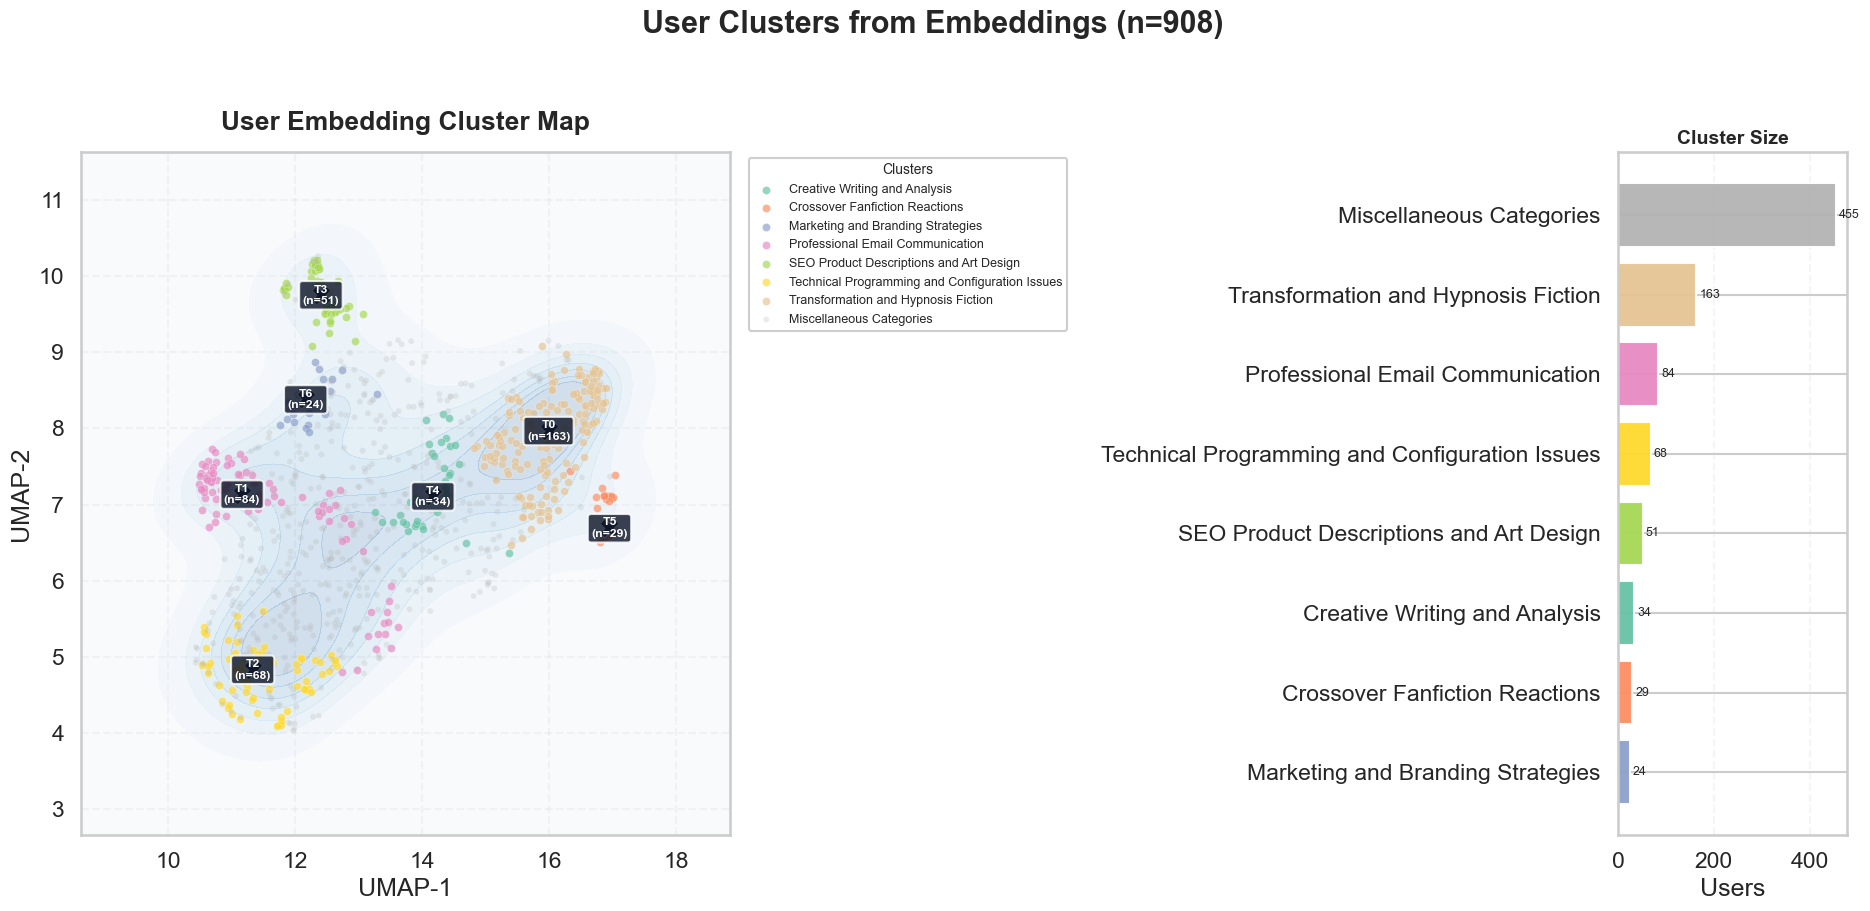

In [109]:
# Plot user clusters (messages)
plot_df = pd.DataFrame({"Topic": topics})
plot_df["Topic"] = plot_df["Topic"].astype(int)

# Create a 2D projection from high-dimensional user embeddings for visualization.
viz_umap = UMAP(
    n_neighbors=25,
    n_components=2,
    min_dist=0.08,
    metric="cosine",
    random_state=42
)
coords_2d = viz_umap.fit_transform(embeddings)

plot_df["x"] = coords_2d[:, 0]
plot_df["y"] = coords_2d[:, 1]

topic_to_label = {t: f"Topic {t}" for t in sorted(plot_df["Topic"].unique())}
if "summaries_df" in globals():
    topic_to_label.update(summaries_df.set_index("Topic")["Category"].to_dict())

plot_df["Cluster"] = plot_df["Topic"].map(topic_to_label)
outlier_mask = plot_df["Topic"] == -1
outlier_label = topic_to_label.get(-1, "Outliers")

non_outlier_labels = sorted(plot_df.loc[~outlier_mask, "Cluster"].unique())
palette = sns.color_palette("Set2", n_colors=max(len(non_outlier_labels), 1))
palette_map = {label: color for label, color in zip(non_outlier_labels, palette)}
palette_map[outlier_label] = (0.70, 0.70, 0.70)

centroids = (
    plot_df.loc[~outlier_mask]
    .groupby(["Topic", "Cluster"], as_index=False)[["x", "y"]]
    .median()
)
cluster_sizes = plot_df["Cluster"].value_counts()

sns.set_theme(style="whitegrid", context="talk")
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(19, 9), gridspec_kw={"width_ratios": [3.4, 1.2]}
)

# Soft density layer for visual depth and cluster concentration.
sns.kdeplot(
    data=plot_df,
    x="x",
    y="y",
    fill=True,
    thresh=0.06,
    levels=8,
    cmap="Blues",
    alpha=0.16,
    ax=ax1
)

for label in non_outlier_labels:
    points = plot_df[plot_df["Cluster"] == label]
    ax1.scatter(
        points["x"],
        points["y"],
        s=34,
        color=palette_map[label],
        alpha=0.68,
        edgecolors="white",
        linewidths=0.25,
        label=label
    )

if outlier_mask.any():
    outliers = plot_df[outlier_mask]
    ax1.scatter(
        outliers["x"],
        outliers["y"],
        s=18,
        color=palette_map[outlier_label],
        alpha=0.24,
        edgecolors="none",
        label=outlier_label
    )

for _, row in centroids.iterrows():
    label = row["Cluster"]
    n = int(cluster_sizes.get(label, 0))
    topic_id = int(row["Topic"])
    ax1.scatter(
        row["x"],
        row["y"],
        s=190,
        marker="X",
        color="#0f172a",
        edgecolors="white",
        linewidths=1.0,
        zorder=5
    )
    ax1.text(
        row["x"],
        row["y"],
        f"T{topic_id}\n(n={n})",
        ha="center",
        va="center",
        fontsize=8.8,
        color="white",
        weight="bold",
        bbox=dict(boxstyle="round,pad=0.28", fc="#0f172a", ec="white", alpha=0.82),
        zorder=6
    )

ax1.set_title("User Embedding Cluster Map", fontsize=19, weight="bold", pad=16)
ax1.set_xlabel("UMAP-1")
ax1.set_ylabel("UMAP-2")
ax1.set_facecolor("#f8fafc")
ax1.grid(alpha=0.18, linestyle="--")

legend = ax1.legend(
    title="Clusters",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    fontsize=9,
    title_fontsize=10
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.96)

plot_order = cluster_sizes.sort_values(ascending=True).index.tolist()
bar_colors = [palette_map.get(label, (0.7, 0.7, 0.7)) for label in plot_order]
counts = cluster_sizes.loc[plot_order].values

ax2.barh(plot_order, counts, color=bar_colors, alpha=0.95)
for i, count in enumerate(counts):
    ax2.text(count + max(counts) * 0.015, i, str(int(count)), va="center", fontsize=9)

ax2.set_title("Cluster Size", fontsize=14, weight="bold")
ax2.set_xlabel("Users")
ax2.set_ylabel("")
ax2.grid(axis="x", alpha=0.18, linestyle="--")
ax2.set_facecolor("#ffffff")

fig.suptitle(f"User Clusters from Embeddings (n={len(plot_df):,})", y=1.02, fontsize=22, weight="bold")
plt.tight_layout()
plt.show()

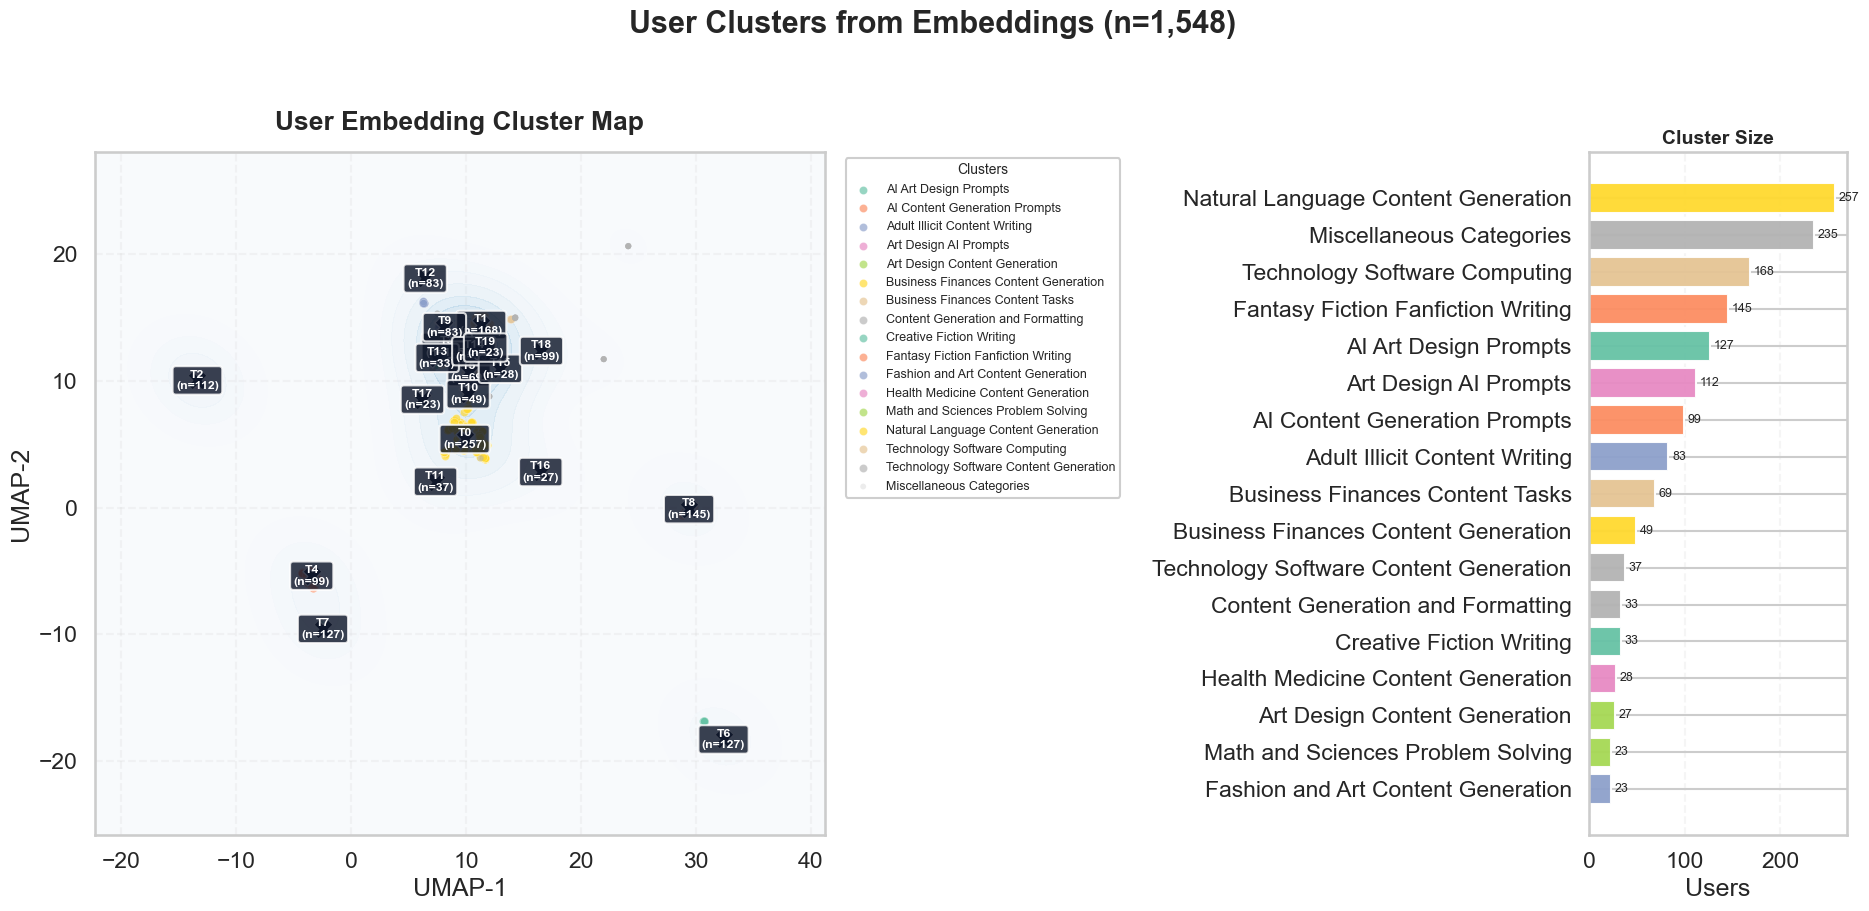

In [ ]:
# Plot user clusters (annotation labels)
plot_df = pd.DataFrame({"Topic": topics})
plot_df["Topic"] = plot_df["Topic"].astype(int)

# Create a 2D projection from high-dimensional user embeddings for visualization.
viz_umap = UMAP(
    n_neighbors=25,
    n_components=2,
    min_dist=0.08,
    metric="cosine",
    random_state=42
)
coords_2d = viz_umap.fit_transform(embeddings)

plot_df["x"] = coords_2d[:, 0]
plot_df["y"] = coords_2d[:, 1]

topic_to_label = {t: f"Topic {t}" for t in sorted(plot_df["Topic"].unique())}
if "summaries_df" in globals():
    topic_to_label.update(summaries_df.set_index("Topic")["Category"].to_dict())

plot_df["Cluster"] = plot_df["Topic"].map(topic_to_label)
outlier_mask = plot_df["Topic"] == -1
outlier_label = topic_to_label.get(-1, "Outliers")

non_outlier_labels = sorted(plot_df.loc[~outlier_mask, "Cluster"].unique())
palette = sns.color_palette("Set2", n_colors=max(len(non_outlier_labels), 1))
palette_map = {label: color for label, color in zip(non_outlier_labels, palette)}
palette_map[outlier_label] = (0.70, 0.70, 0.70)

centroids = (
    plot_df.loc[~outlier_mask]
    .groupby(["Topic", "Cluster"], as_index=False)[["x", "y"]]
    .median()
)
cluster_sizes = plot_df["Cluster"].value_counts()

sns.set_theme(style="whitegrid", context="talk")
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(19, 9), gridspec_kw={"width_ratios": [3.4, 1.2]}
)

# Soft density layer for visual depth and cluster concentration.
sns.kdeplot(
    data=plot_df,
    x="x",
    y="y",
    fill=True,
    thresh=0.06,
    levels=8,
    cmap="Blues",
    alpha=0.16,
    ax=ax1
)

for label in non_outlier_labels:
    points = plot_df[plot_df["Cluster"] == label]
    ax1.scatter(
        points["x"],
        points["y"],
        s=34,
        color=palette_map[label],
        alpha=0.68,
        edgecolors="white",
        linewidths=0.25,
        label=label
    )

if outlier_mask.any():
    outliers = plot_df[outlier_mask]
    ax1.scatter(
        outliers["x"],
        outliers["y"],
        s=18,
        color=palette_map[outlier_label],
        alpha=0.24,
        edgecolors="none",
        label=outlier_label
    )

for _, row in centroids.iterrows():
    label = row["Cluster"]
    n = int(cluster_sizes.get(label, 0))
    topic_id = int(row["Topic"])
    ax1.scatter(
        row["x"],
        row["y"],
        s=190,
        marker="X",
        color="#0f172a",
        edgecolors="white",
        linewidths=1.0,
        zorder=5
    )
    ax1.text(
        row["x"],
        row["y"],
        f"T{topic_id}\n(n={n})",
        ha="center",
        va="center",
        fontsize=8.8,
        color="white",
        weight="bold",
        bbox=dict(boxstyle="round,pad=0.28", fc="#0f172a", ec="white", alpha=0.82),
        zorder=6
    )

ax1.set_title("User Embedding Cluster Map", fontsize=19, weight="bold", pad=16)
ax1.set_xlabel("UMAP-1")
ax1.set_ylabel("UMAP-2")
ax1.set_facecolor("#f8fafc")
ax1.grid(alpha=0.18, linestyle="--")

legend = ax1.legend(
    title="Clusters",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    fontsize=9,
    title_fontsize=10
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.96)

plot_order = cluster_sizes.sort_values(ascending=True).index.tolist()
bar_colors = [palette_map.get(label, (0.7, 0.7, 0.7)) for label in plot_order]
counts = cluster_sizes.loc[plot_order].values

ax2.barh(plot_order, counts, color=bar_colors, alpha=0.95)
for i, count in enumerate(counts):
    ax2.text(count + max(counts) * 0.015, i, str(int(count)), va="center", fontsize=9)

ax2.set_title("Cluster Size", fontsize=14, weight="bold")
ax2.set_xlabel("Users")
ax2.set_ylabel("")
ax2.grid(axis="x", alpha=0.18, linestyle="--")
ax2.set_facecolor("#ffffff")

fig.suptitle(f"User Clusters from Embeddings (n={len(plot_df):,})", y=1.02, fontsize=22, weight="bold")
plt.tight_layout()
plt.show()

## User Preference Analysis

In [40]:
preference_dimensions = {
    "expertise": ["responses that can be easily understood by beginners", "responses with expert-level knowledge"],
    "informativeness": ["responses that provide concise information", "responses that provide in-depth and comprehensive information"],
    "tone": ["responses with a casual and friendly tone", "responses with a formal and professional tone"],
    "structure": ["responses that are structured with a clear and logical flow", "responses that are unstructured and free-form"],
    "creativity": ["responses that are highly creative and original", "responses that are more conventional and predictable"],
    "engagement": ["responses that encourage user interaction and engagement", "responses that are more informative and less interactive"],
}

In [41]:
user_messages = doc[:50]

In [42]:
def classify_user_preferences(user_messages, client, preference_dimensions):
    """
    Classify user preferences for each document using GPT-4o.
    
    Args:
        user_messages: List of strings, each containing concatenated user messages
        client: OpenAI client instance
        preference_dimensions: Dictionary of preference dimensions
    
    Returns:
        List of dictionaries containing classifications for each user
    """
    results = []
    
    for idx, messages in enumerate(user_messages):
        print(f"Processing user {idx + 1}/{len(user_messages)}...")
        
        # Create the classification prompt
        prompt = f"""Analyze the following user messages and classify their preferences across different dimensions.

User Messages:
{messages}

For each dimension below, determine whether the user prefers option 1, option 2, or shows no clear preference based on their message patterns, questions, and interaction style.

Preference Dimensions:
"""
        
        for dimension, (pref1, pref2) in preference_dimensions.items():
            prompt += f"\n{dimension.upper()}:\n- Preference 1: {pref1}\n- Preference 2: {pref2}\n"
        
        prompt += """
Please respond in the following JSON format:
{
    "expertise": "preference 1" | "preference 2" | "no clear preference",
    "informativeness": "preference 1" | "preference 2" | "no clear preference",
    "tone": "preference 1" | "preference 2" | "no clear preference",
    "structure": "preference 1" | "preference 2" | "no clear preference",
    "creativity": "preference 1" | "preference 2" | "no clear preference",
    "engagement": "preference 1" | "preference 2" | "no clear preference"
}

Only output the JSON, nothing else."""
        
        try:
            # Call GPT-4o
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are an expert at analyzing user communication patterns and preferences. Provide classifications in valid JSON format only."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3,
                response_format={"type": "json_object"}
            )
            
            # Parse the response
            import json
            classification = json.loads(response.choices[0].message.content)
            
            results.append({
                "user_index": idx,
                "classifications": classification
            })
            
        except Exception as e:
            print(f"Error processing user {idx}: {e}")
            results.append({
                "user_index": idx,
                "classifications": {dim: "error" for dim in preference_dimensions.keys()}
            })
    
    return results


# Run the classification
results = classify_user_preferences(user_messages, client, preference_dimensions)

Processing user 1/50...
Processing user 2/50...
Processing user 3/50...
Processing user 4/50...
Processing user 5/50...
Processing user 6/50...
Processing user 7/50...
Processing user 8/50...
Processing user 9/50...
Processing user 10/50...
Processing user 11/50...
Processing user 12/50...
Processing user 13/50...
Processing user 14/50...
Processing user 15/50...
Processing user 16/50...
Processing user 17/50...
Processing user 18/50...
Processing user 19/50...
Processing user 20/50...
Processing user 21/50...
Processing user 22/50...
Processing user 23/50...
Processing user 24/50...
Processing user 25/50...
Processing user 26/50...
Processing user 27/50...
Processing user 28/50...
Processing user 29/50...
Processing user 30/50...
Processing user 31/50...
Processing user 32/50...
Processing user 33/50...
Processing user 34/50...
Processing user 35/50...
Processing user 36/50...
Processing user 37/50...
Processing user 38/50...
Processing user 39/50...
Processing user 40/50...
Processin

In [43]:
# Print the final results
print("FINAL CLASSIFICATION RESULTS")

for dimension, (pref1_desc, pref2_desc) in preference_dimensions.items():
    # Count preferences for this dimension
    pref1_count = sum(1 for r in results if r["classifications"].get(dimension) == "preference 1")
    pref2_count = sum(1 for r in results if r["classifications"].get(dimension) == "preference 2")
    no_pref_count = sum(1 for r in results if r["classifications"].get(dimension) == "no clear preference")

    # Print the results
    print(f'"{dimension}":')
    print(f'  * "{pref1_desc}" - {pref1_count} users')
    print(f'  * "{pref2_desc}" - {pref2_count} users')
    print(f'  * "no clear preference" - {no_pref_count} users')
    print()

FINAL CLASSIFICATION RESULTS
"expertise":
  * "responses that can be easily understood by beginners" - 8 users
  * "responses with expert-level knowledge" - 33 users
  * "no clear preference" - 9 users

"informativeness":
  * "responses that provide concise information" - 18 users
  * "responses that provide in-depth and comprehensive information" - 29 users
  * "no clear preference" - 3 users

"tone":
  * "responses with a casual and friendly tone" - 14 users
  * "responses with a formal and professional tone" - 22 users
  * "no clear preference" - 14 users

"structure":
  * "responses that are structured with a clear and logical flow" - 40 users
  * "responses that are unstructured and free-form" - 7 users
  * "no clear preference" - 3 users

"creativity":
  * "responses that are highly creative and original" - 23 users
  * "responses that are more conventional and predictable" - 12 users
  * "no clear preference" - 15 users

"engagement":
  * "responses that encourage user interacti